In [1]:
!python -V
!pip show torch

Python 3.6.5
Name: torch
Version: 1.8.0+cu111
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: c:\users\b\desktop\direct_dcrnn\env\lib\site-packages
Requires: dataclasses, typing-extensions, numpy
Required-by: torchvision, torchaudio


In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette(palette='magma', n_colors=3)
sns.set_style("darkgrid")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset

from sklearn.model_selection import train_test_split
from Resnet_adaptation import new_cnn_model

In [3]:
# set seeds
SEED = 99
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [4]:
# Set compute device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)

cuda


In [5]:
# get scalers
training_set = np.load('./data/train.npz')

mean = round(training_set['x'][...,0].mean(), 2)
std = round(training_set['x'][...,0].std(), 2)

print("Mean ={}, Std = {}".format(mean, std))

Mean =4090.28, Std = 2164.09


In [6]:
# data sources: Configured for oracle

# The training data used to train GC-GRNN
inputs = np.squeeze(training_set['x'][0:9152])
print(f'shape = {inputs.shape}, Max = {np.max(inputs)}')

ground_truths = np.squeeze(training_set['y'][0:9152])
print(f'shape = {ground_truths.shape}, Max = {np.max(ground_truths)}')

# Predictions of GC-GRNN on the inputs i.e. training set itself
preds_on_inputs = np.load('./DCRNN-Preds-on-Inputs/dcrnn_output_on_train.npz')
dcrnn_preds = np.squeeze(preds_on_inputs['predictions'])
#changed below shape

print(f'shape = {dcrnn_preds.shape}, Max = {np.max(dcrnn_preds)}')

shape = (9152, 12, 150), Max = 13442.0
shape = (9152, 12, 150), Max = 13442.0
shape = (12, 9152, 150), Max = 12063.5791015625


In [7]:
# Now the training takes place on inputs and predictions

In [8]:
print(dcrnn_preds[10][15][16])
time_steps, samples, nodes = dcrnn_preds.shape

dcrnn_preds_reshaped=[]
for a in range(samples):
    all_time_steps_all_nodes=[]
    for i in range(time_steps):
        for j in range(samples):
            if j==a:
                node_collect=[]
                for k in range(nodes):
                    node_collect.append(dcrnn_preds[i][j][k])
                all_time_steps_all_nodes.append(node_collect)
    dcrnn_preds_reshaped.append(all_time_steps_all_nodes)
    
dcrnn_preds_reshaped= np.array(dcrnn_preds_reshaped)
print(dcrnn_preds_reshaped.shape)
print(dcrnn_preds_reshaped[15][10][16])

6206.791
(9152, 12, 150)
6206.791


In [9]:
# Norm/ Denorm
# We need all 3 sources to have same shape
# We need all 3 sources to be normalized
inputs = (inputs - mean)/std
ground_truths = (ground_truths - mean)/std
# dcrnn_preds are also not normalized

dcrnn_preds_reshaped = (dcrnn_preds_reshaped - mean)/std

print(f'shape = {inputs.shape}, Max = {np.max(inputs)}')
print(f'shape = {ground_truths.shape}, Max = {np.max(ground_truths)}')
print(f'shape = {dcrnn_preds.shape}, Max = {np.max(dcrnn_preds)}')

shape = (9152, 12, 150), Max = 4.321317505279355
shape = (9152, 12, 150), Max = 4.321317505279355
shape = (12, 9152, 150), Max = 12063.5791015625


In [10]:
x_train = inputs
# Oracle means, y = gcgrnn preds
y_train = dcrnn_preds_reshaped
print("Training data: ", len(x_train), len(y_train))

Training data:  9152 9152


In [11]:
# testing will take place in the test set

In [12]:
# just select to make it divisible by 12 or 64 ?
test_set = np.load('./data/test.npz')

test_inputs = np.squeeze(test_set['x'])
test_gts = np.squeeze(test_set['y'])

#gcgrnn predictions on test set are in best model op 
test_op = np.load('./best_model/best_model_output.npz')
test_preds = np.squeeze(test_op['predictions'][0:2616])


print(f'shape = {test_inputs.shape}, Max = {np.max(test_inputs)}')
print(f'shape = {test_gts.shape}, Max = {np.max(test_gts)}')
print(f'shape = {test_preds.shape}, Max = {np.max(test_preds)}')

# we need them normalized and reshaped
test_inputs = (test_inputs - mean)/std
test_gts = (test_gts - mean)/std

shape = (2616, 12, 150), Max = 11644.0
shape = (2616, 12, 150), Max = 11644.0
shape = (12, 2616, 150), Max = 11103.59765625


In [13]:
print(test_preds[10][15][16])
time_steps, samples, nodes = test_preds.shape
test_preds_dcrnn=[]

test_preds_dcrnn=[]
for a in range(samples):
    all_time_steps_all_nodes=[]
    for i in range(time_steps):
        for j in range(samples):
            if j==a:
                node_collect=[]
                for k in range(nodes):
                    node_collect.append(test_preds[i][j][k])
                all_time_steps_all_nodes.append(node_collect)
    test_preds_dcrnn.append(all_time_steps_all_nodes)
    
test_preds_dcrnn= np.array(test_preds_dcrnn)
print(test_preds_dcrnn.shape)
print(test_preds_dcrnn[15][10][16])

6339.116
(2616, 12, 150)
6339.116


In [14]:
test_preds_dcrnn = (test_preds_dcrnn-mean)/std

print(f'\nshape = {test_inputs.shape}, Max = {np.max(test_inputs)}')
print(f'shape = {test_gts.shape}, Max = {np.max(test_gts)}')
print(f'shape = {test_preds_dcrnn.shape}, Max = {np.max(test_preds_dcrnn)}')

x_test = test_inputs
y_test = test_preds_dcrnn

print("Testing data: ", len(x_test), len(y_test))


shape = (2616, 12, 150), Max = 3.4904832978295723
shape = (2616, 12, 150), Max = 3.4904832978295723
shape = (2616, 12, 150), Max = 3.240769624710083
Testing data:  2616 2616


In [15]:
# Define dataset
class TR_dataset(Dataset):
    def __init__(self, data_list, target_list):
        self.data_list = data_list
        self.target_list = target_list
        
    def __len__(self):
        assert len(self.target_list) == len(self.data_list)
        return len(self.data_list)

    def __getitem__(self, key):
        input_seq = self.data_list[key]
        targets = self.target_list[key]
        return [input_seq,targets]

In [16]:
# Make dataloaders
# Shuffle set to False

BATCH_SIZE = 12
TEST_BATCH_SIZE =1

train_set = TR_dataset(x_train, y_train)
test_set = TR_dataset(x_test,y_test)

train_dataloader = torch.utils.data.DataLoader(dataset=train_set,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=None,
                                               shuffle=False)

test_dataloader = torch.utils.data.DataLoader(dataset=test_set,
                                               batch_size=TEST_BATCH_SIZE,
                                               collate_fn=None,
                                               shuffle=False)

In [17]:
# Instantiate a ResNet adaptation model here
# See the model file for full model architecture
model = new_cnn_model.ResNet_Adaptation_model()
model = model.float().to(device)

In [18]:
# MSE
criterion = nn.MSELoss(reduction='mean')
#criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [19]:
def train(model, iterator, optimizer, criterion):
    
    model.train()
    epoch_loss = 0
    
    for i, (batch_input, batch_target) in enumerate(iterator):
        
        batch_input = batch_input.float().to(device)
        #print(batch_target.shape)
        batch_target = torch.flatten(batch_target.float(), start_dim=1).to(device)
        #print(batch_target.shape)
        optimizer.zero_grad()
        
        output = model(batch_input)
        
        mse_loss = criterion(output, batch_target)
        #RMSE, MSE not enough
        loss = torch.sqrt(mse_loss)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss+=loss.cpu().detach().numpy()
        #epoch_loss+=loss.item()
        
    # Average batch loss in an epoch
    return epoch_loss/len(iterator) 

In [20]:
# can include a validation loss every epoch
def validate():
    return 0

In [21]:
# No need to apply softmax or measure accuracy 

# For now only 350, later change to 1500
num_epochs = 80
#num_epochs = 2

# Over total epochs
loss_epoch =[]
best_loss = float('inf')

for i in range(num_epochs):
    
    # Loss is averaged in an epoch. so this is average batch loss per epoch
    loss = train(model, train_dataloader, optimizer,criterion )
    print("Normalized RMSE Loss (Average Batch Loss)=", loss)
    
    if loss < best_loss:
        best_loss = loss
        # Save the entire model, not just state_dict
        torch.save(model, './helper_files/best_model_CNN.pt')
        
    loss_epoch.append(round(loss,2))
print("Best Loss = ", best_loss)

Normalized RMSE Loss (Average Batch Loss)= 0.41596763517565993
Normalized RMSE Loss (Average Batch Loss)= 0.31584417185261554
Normalized RMSE Loss (Average Batch Loss)= 0.2913209128036099
Normalized RMSE Loss (Average Batch Loss)= 0.28100534529470367
Normalized RMSE Loss (Average Batch Loss)= 0.2777824641094295
Normalized RMSE Loss (Average Batch Loss)= 0.273956439695852
Normalized RMSE Loss (Average Batch Loss)= 0.2740082022481321
Normalized RMSE Loss (Average Batch Loss)= 0.26955678797330646
Normalized RMSE Loss (Average Batch Loss)= 0.2672079104739748
Normalized RMSE Loss (Average Batch Loss)= 0.2656666123031164
Normalized RMSE Loss (Average Batch Loss)= 0.26261034047384874
Normalized RMSE Loss (Average Batch Loss)= 0.26214364122203887
Normalized RMSE Loss (Average Batch Loss)= 0.26111622105888427
Normalized RMSE Loss (Average Batch Loss)= 0.26005691731272956
Normalized RMSE Loss (Average Batch Loss)= 0.259155260801784
Normalized RMSE Loss (Average Batch Loss)= 0.2584552207514937
No

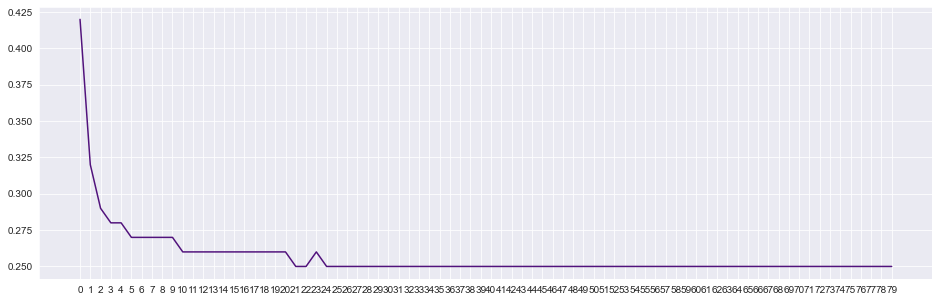

In [22]:
# Train loss curve
x = np.arange(num_epochs)
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(x, loss_epoch)
ax.set_xticks(x);

In [23]:
trained_model = torch.load('./helper_files/best_model_CNN.pt')
trained_model.eval()
outputs = []

with torch.no_grad():
    for bi, (data, target) in enumerate(test_dataloader):
        
        data_batch, label_batch = data.float().to(device), target.float().to(device)
        
        output_batch = trained_model(data_batch)
        
        # add cpu() before detach if device changed to GPU
        output_batch_numpy = output_batch.cpu().detach().numpy().reshape(12,-1)
        
        #print(output_batch_numpy.shape)
        outputs.append(output_batch_numpy)
outputs = np.array(outputs)
print(outputs.shape)

np.save('./helper_files/resnet_test_output.npy', outputs)

(2616, 12, 150)


In [24]:
# From the test set
inputs = test_inputs
print(f'Inputs: shape = {inputs.shape}, min = {np.min(inputs)}, max = {np.max(inputs)}')

# ground truths of these inputs
# The could be y_test as well
gts_test = test_gts
print(f'GTS: shape = {gts_test.shape}, min = {np.min(inputs)}, max = {np.max(gts_test)}')

# GC_GRNN preds
dcrnn_preds = test_preds_dcrnn
print(f'DCRNNPreds: shape = {dcrnn_preds.shape}, min = {np.min(dcrnn_preds)}, max = {np.max(dcrnn_preds)}')

# ResNet preds
resnet_preds = np.load('./helper_files/resnet_test_output.npy', allow_pickle = True)
print(f'ResNetPreds: shape = {resnet_preds.shape}, min = {np.min(resnet_preds)}, max = {np.max(resnet_preds)}')

#Denormalize everything
inputs = inputs*std+mean
print(f'\nInputs: shape = {inputs.shape}, min = {np.min(inputs)}, max = {np.max(inputs)}')

gts_test = gts_test*std+mean
print(f'GTS: shape = {gts_test.shape}, min = {np.min(inputs)}, max = {np.max(gts_test)}')

dcrnn_preds = dcrnn_preds*std+mean
print(f'DCRNNPreds: shape = {dcrnn_preds.shape}, min = {np.min(dcrnn_preds)}, max = {np.max(dcrnn_preds)}')

resnet_preds = resnet_preds*std+mean
print(f'ResNetPreds: shape = {resnet_preds.shape}, min = {np.min(resnet_preds)}, max = {np.max(resnet_preds)}')

Inputs: shape = (2616, 12, 150), min = -1.8900692669898203, max = 3.4904832978295723
GTS: shape = (2616, 12, 150), min = -1.8900692669898203, max = 3.4904832978295723
DCRNNPreds: shape = (2616, 12, 150), min = -1.9644354581832886, max = 3.240769624710083
ResNetPreds: shape = (2616, 12, 150), min = -2.8879785537719727, max = 2.611392021179199

Inputs: shape = (2616, 12, 150), min = 0.0, max = 11644.0
GTS: shape = (2616, 12, 150), min = 0.0, max = 11644.0
DCRNNPreds: shape = (2616, 12, 150), min = -160.935302734375, max = 11103.59765625
ResNetPreds: shape = (2616, 12, 150), min = -2159.565673828125, max = 9741.5673828125


In [25]:
def get_metrics(pred, truth):
    
    # assert both have same lengths
    num_signals = len(pred)
    #print(num_signals)
    
    number_of_nodes = 150
    time_steps = 12

    rmse_collect = []
    rmse = 0.0
    
    for i in range(num_signals):
        rmse_signal = np.sum(np.square(pred[i]- truth[i]))
        
        # save this to true rmse first
        rmse+= rmse_signal
        
        # arrange to collect
        rmse_signal = np.sqrt(rmse_signal/(time_steps*number_of_nodes))
        
        # collect it
        rmse_collect.append(round(rmse_signal,2))
        

    rmse = np.sqrt(rmse/(num_signals*time_steps*number_of_nodes))
    #print(rmse)
    rmse_collect = np.array(rmse_collect)
    
    return rmse, rmse_collect

In [26]:
rmse_dcrnn, rmse_collect = get_metrics(dcrnn_preds, gts_test)
RMSE_collect_DCRNN = rmse_collect

print("True RMSE: ", round(rmse_dcrnn,2))

print("\nSignal wise collection: ")
print(f'Max ={np.max(RMSE_collect_DCRNN)}, Mean={round(np.mean(RMSE_collect_DCRNN),2)}, Shape={RMSE_collect_DCRNN.shape}')

True RMSE:  770.04

Signal wise collection: 
Max =1764.15, Mean=734.66, Shape=(2616,)


In [27]:
rmse_resnet, rmse_collect = get_metrics(resnet_preds, gts_test)
RMSE_collect_Resnet = rmse_collect

print("True RMSE: ", round(rmse_resnet,2))

print("\nSignal wise collection: ")
print(f'Max ={np.max(RMSE_collect_Resnet)}, Mean={round(np.mean(RMSE_collect_Resnet),2)}, Shape={RMSE_collect_Resnet.shape}')

True RMSE:  1196.3

Signal wise collection: 
Max =2082.89, Mean=1171.9, Shape=(2616,)


Text(0, 0.5, 'Number of signals')

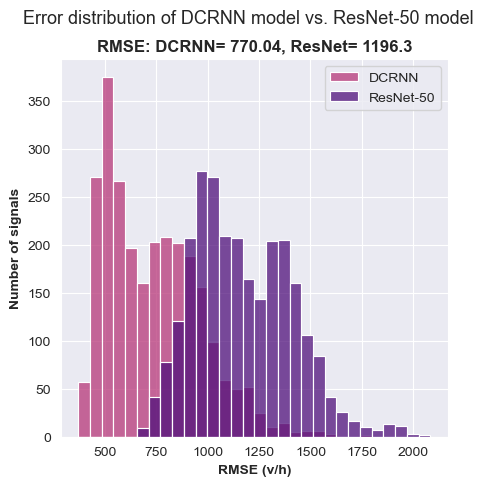

In [28]:
# RMSE dstr of GC-GRNN predictions, RMSE Dstr of ResNet predictions
# RMSE Error distribution shift
#mean_gc = np.mean(RMSE_collect_GC_GRNN)
#mean_rn = np.mean(RMSE_collect_Resnet)

labels =["DCRNN","ResNet-50"]
fig, axes =plt.subplots(figsize=(5,5),dpi=100)
fig.suptitle('Error distribution of DCRNN model vs. ResNet-50 model', fontsize=13)

rmse_plot = sns.histplot(data=[RMSE_collect_Resnet, RMSE_collect_DCRNN], bins=30, kde=False, fill=True)
axes.set_title('RMSE: DCRNN= {}, ResNet= {}'.format(str(round(rmse_dcrnn,2)), str(round(rmse_resnet,2))), fontweight='bold')
axes.legend(labels)
axes.set_xlabel('RMSE (v/h)', fontweight='bold')
axes.set_ylabel('Number of signals', fontweight='bold')

In [29]:
np.argwhere(1.2*RMSE_collect_DCRNN < RMSE_collect_Resnet) #??

array([[   0],
       [   1],
       [   2],
       ...,
       [2613],
       [2614],
       [2615]], dtype=int64)

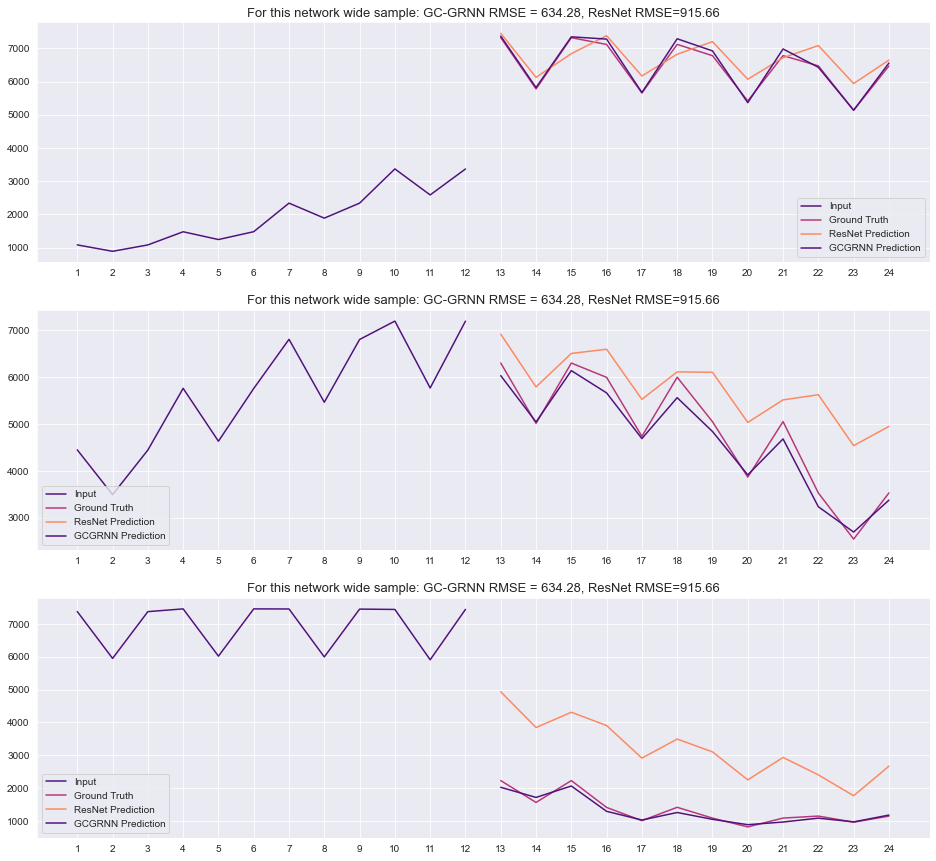

In [30]:
# Do some predictions with the trained model and observe outputs
# Plot corresponding input and corresponding (ResNet Pred, GC-GRNN pred, GT) 
data_select = 99

inpt = inputs[data_select]
gt = gts_test[data_select]
rn_pred = resnet_preds[data_select]
gc_pred = dcrnn_preds[data_select]
er_DCRNN = RMSE_collect_DCRNN[data_select]
er_Resnet = RMSE_collect_Resnet[data_select]

num = 3
inpt = inpt[:,0:num].reshape(num,12)
gt = gt [:,0:num].reshape(num,12)
rn_pred = rn_pred[:,0:num].reshape(num,12)
gc_pred = gc_pred[:,0:num].reshape(num,12)

total_x = np.arange(1,25,1)
x_pred = np.arange(13,25,1)
x_inpt = np.arange(1,13,1)

fig, ax = plt.subplots(num,1,figsize=(16,num*5))

ax[0].plot(x_inpt,inpt[0])
ax[0].plot(x_pred,gt[0])
ax[0].plot(x_pred,rn_pred[0])
ax[0].plot(x_pred,gc_pred[0])
ax[0].set_title(f'For this network wide sample: GC-GRNN RMSE = {er_DCRNN}, ResNet RMSE={er_Resnet}', fontsize=13);
ax[0].set_xticks(total_x);
ax[0].legend(["Input", "Ground Truth", "ResNet Prediction","GCGRNN Prediction" ], loc='lower right')

ax[1].plot(x_inpt,inpt[1])
ax[1].plot(x_pred,gt[1])
ax[1].plot(x_pred,rn_pred[1])
ax[1].plot(x_pred,gc_pred[1])
ax[1].set_title(f'For this network wide sample: GC-GRNN RMSE = {er_DCRNN}, ResNet RMSE={er_Resnet}', fontsize=13);
ax[1].set_xticks(total_x);
ax[1].legend(["Input", "Ground Truth", "ResNet Prediction","GCGRNN Prediction" ], loc='lower left')

ax[2].plot(x_inpt,inpt[2])
ax[2].plot(x_pred,gt[2])
ax[2].plot(x_pred,rn_pred[2])
ax[2].plot(x_pred,gc_pred[2])
ax[2].set_title(f'For this network wide sample: GC-GRNN RMSE = {er_DCRNN}, ResNet RMSE={er_Resnet}', fontsize=13);
ax[2].set_xticks(total_x);
ax[2].legend(["Input", "Ground Truth", "ResNet Prediction","GCGRNN Prediction" ], loc='lower left')